In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor, MolsToGridImage
from rdkit.Chem import MolFromSmiles, MACCSkeys

rdDepictor.SetPreferCoordGen(True)
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#F06060", "#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

In [2]:
# scramble them
# Reduced for CI!
# soldata = soldata.sample(frac=0.01, random_state=0).reset_index(drop=False)
# soldata.head()

In [3]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]
len(selfies_list)

9982

In [4]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(
    sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None])
)
vocab = ['[nop]']
vocab.extend(list(data_vocab.union(basic)))
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}


def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue  # ?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            # print('Warning')
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s.replace(
    '.', ''
)  # make sure '.' is removed from Selfies string during assertion

selfies: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C].[Br-expl]
selfies2ints: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 201, 133, 126, 126, 133, 126, 126, 126, 61]
ints2selfes: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][N+expl][Branch1_1][C][C][Branch1_1][C][C][C][Br-expl]


In [5]:
#creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=256,
    hidden_dim=128,
    rnn_units=128,
)

In [6]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values)
)
# now split into val, test, train and batch
N = len(data)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), nontest.skip(
    split
).shuffle(config.buffer_size).batch(config.batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
)

In [7]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(
        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
    )
)

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         54528     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 219,393
Trainable params: 219,393
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)

Epoch 1/100
500/500 - 5s - loss: 4.3591 - val_loss: 5.1572
Epoch 2/100
500/500 - 4s - loss: 2.3299 - val_loss: 4.9961
Epoch 3/100
500/500 - 4s - loss: 2.1599 - val_loss: 4.2906
Epoch 4/100
500/500 - 4s - loss: 2.0434 - val_loss: 4.0629
Epoch 5/100
500/500 - 4s - loss: 1.9714 - val_loss: 4.4961
Epoch 6/100
500/500 - 4s - loss: 1.9156 - val_loss: 4.2999
Epoch 7/100
500/500 - 4s - loss: 1.8754 - val_loss: 4.0340
Epoch 8/100
500/500 - 4s - loss: 1.8316 - val_loss: 3.9418
Epoch 9/100
500/500 - 4s - loss: 1.7901 - val_loss: 4.3643
Epoch 10/100
500/500 - 4s - loss: 1.7902 - val_loss: 3.8228
Epoch 11/100
500/500 - 4s - loss: 1.7412 - val_loss: 4.2100
Epoch 12/100
500/500 - 4s - loss: 1.7360 - val_loss: 3.9537
Epoch 13/100
500/500 - 4s - loss: 1.6918 - val_loss: 3.8926
Epoch 14/100
500/500 - 4s - loss: 1.6868 - val_loss: 4.3007
Epoch 15/100
500/500 - 4s - loss: 1.6435 - val_loss: 4.1123
Epoch 16/100
500/500 - 4s - loss: 1.6236 - val_loss: 3.9436
Epoch 17/100
500/500 - 4s - loss: 1.6121 - val_lo

In [9]:
model.save('solubility-rnn-accurate')
# model = tf.keras.models.load_model('solubility-rnn-accurate/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: solubility-rnn-accurate/assets


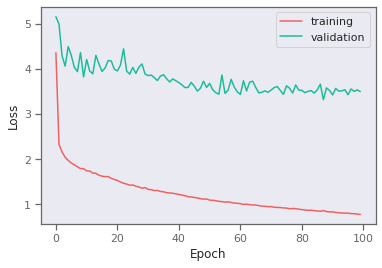

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('rnn-loss.png', bbox_inches="tight", dpi=180)

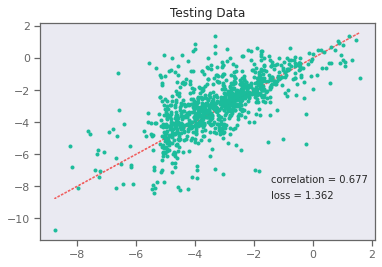

In [11]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(max(test_y) - 3, min(test_y) + 1, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(max(test_y) - 3, min(test_y), f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


### Description of AqSolDB data

Compounds can be classified according to solubility values (LogS); Compounds with 0 and higher solubility value are highly soluble, those in the range of 0 to −2 are soluble, those in the range of −2 to −4 are slightly soluble and insoluble if less than −4.

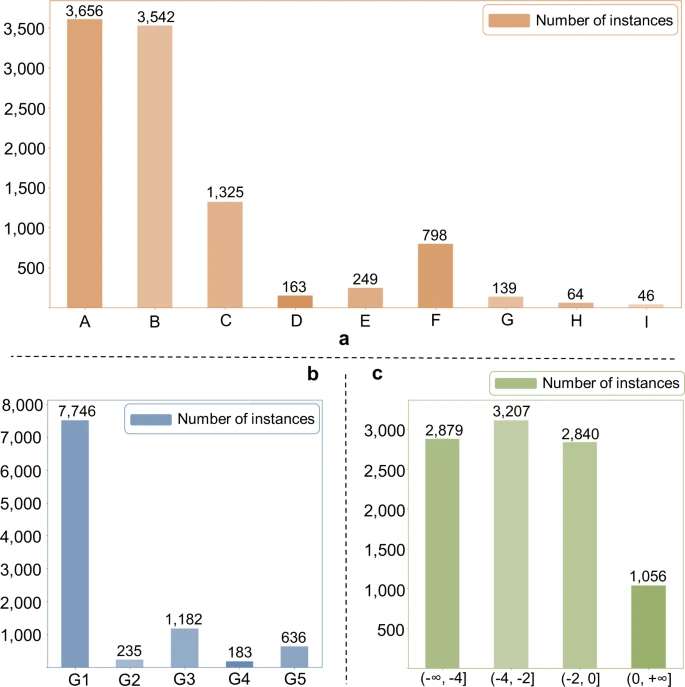

## LIME explanations

In the following example, we find out what descriptors influence solubility of a molecules. For example, let's say we have a molecule with LogS=1.5. We create a perturbed chemical space around that molecule using `stoned` method and then use `lime` to find out which descriptors affect solubility predictions for that molecule. 

### Define functions used for this method

In [12]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [13]:
def feature_dict(space):
    features = {a: b for a, b in zip(space[0].descriptors.descriptor_names, 
                                     np.arange(len(space[0].descriptors.descriptors)))}
    return features

In [14]:
def calc_ft_imp(space, space_tstats):
    from collections import OrderedDict
    feature_importance = {a: b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats) if abs(b) > 2.96}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

In [15]:
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.offsetbox import AnnotationBbox
import textwrap
import skunk

def plot_desc(feature_importance, desc_type, output_file, title=None, ax = None):
    t = list(feature_importance.values())
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    keys = list(feature_importance.keys())

    if len(t) > 0:
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
            print(t)
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        count = 1
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 20)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.5
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=8)
                count+=1
            else:
                x = -0.5
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=8)
                count+=1
            
        ax.set_xlim(-np.max(np.absolute(t))-1, np.max(np.absolute(t))+1)
    else:
        patch = ax.get_ylim()
        print(patch)
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=8)
    
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_xlabel('Feature t-statistics', fontsize=10)
    ax.set_title(title, fontsize=10)
    if output_file is not None:
        plt.savefig(output_file, dpi = 300, bbox_inches='tight')

In [16]:
from typing import *
from exmol.plot_utils import _mol_images, _image_scatter
from exmol.data import Example

def plot_space_by_fit(
    examples: List[Example],
    exps: List[Example],
    beta: List = None,
    figure_kwargs: Dict = None,
    colorbar: bool=True,
    mol_size: Tuple[int, int] = (200, 200),
    highlight_clusters: bool = False,
    mol_fontsize: int = 8,
    offset: int = 0,
    ax: Any = None,
    cartoon: bool = False,
    rasterized: bool = False,
):
    """Plot chemical space around example by LIME fit and annotate given examples.
    :param examples: Large list of :obj:Example which make-up points
    :param exps: Small list of :obj:Example which will be annotated
    :param figure_kwargs: kwargs to pass to :func:`plt.figure<matplotlib.pyplot.figure>`
    :param mol_size: size of rdkit molecule rendering, in pixles
    :param highlight_clusters: if `True`, cluster indices are rendered instead of :obj:Example.yhat
    :param mol_fontsize: minimum font size passed to rdkit
    :param offset: offset annotations to allow colorbar or other elements to fit into plot.
    :param ax: axis onto which to plot
    :param cartoon: do cartoon outline on points?
    :param rasterized: raster the scatter?
    """
    imgs = _mol_images(exps, mol_size, mol_fontsize)
    if figure_kwargs is None:
        figure_kwargs = {"figsize": (12, 8)}
    base_color = "gray"
    if ax is None:
        ax = plt.figure(**figure_kwargs).gca()
    if highlight_clusters:
        colors = [e.cluster for e in examples]
        def normalizer(x):
            return x
        cmap = "Accent"
        
    if beta is None:
        raise ValueError('beta must be provided to plot by fit')
    yhat = [e.yhat for e in examples]
    yhat -= np.mean(yhat)
    x_mat = np.array([list(e.descriptors.descriptors)
                        for e in examples]).reshape(len(examples), -1)
    y = x_mat @ beta
    # use resids as colors
    colors = (yhat - y)**2
    normalizer = plt.Normalize(min(colors), max(colors))
    cmap = "PuBu_r"

    space_x = [e.position[0] for e in examples]
    space_y = [e.position[1] for e in examples]
    if cartoon:
        # plot shading, lines, front
        ax.scatter(space_x, space_y, 50, "0.0", lw=2, rasterized=rasterized)
        ax.scatter(space_x, space_y, 50, "1.0", lw=0, rasterized=rasterized)
        ax.scatter(
            space_x,
            space_y,
            50,
            c=normalizer(colors),
            cmap=cmap,
            lw=2,
            alpha=0.1,
            rasterized=rasterized,
        )
    else:
        im = ax.scatter(
                space_x,
                space_y,
                50,
                c=normalizer(colors),
                cmap=cmap,
                edgecolors="grey",
                linewidth=0.1
            )
    if colorbar:
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        cbar = plt.colorbar(im, orientation="horizontal", aspect=35, pad=0.05)
        cbar.set_label('squared error')

    # now plot cfs/annotated points
    ax.scatter(
        [e.position[0] for e in exps],
        [e.position[1] for e in exps],
        c=normalizer([e.cluster if highlight_clusters else e.yhat for e in exps]),
        cmap=cmap,
        edgecolors="black",
    )

    x = [e.position[0] for e in exps]
    y = [e.position[1] for e in exps]
    titles = []
    colors = []
    for e in exps:
        if not e.is_origin:
            titles.append(f"Similarity = {e.similarity:.2f}\nf(x)={e.yhat:.3f}")
            colors.append(cast(Any, base_color))
        else:
            titles.append(f"Base \nf(x)={e.yhat:.3f}")
            colors.append(cast(Any, base_color))
    _image_scatter(x, y, imgs, titles, colors, ax, offset=offset)
    ax.axis("off")
    ax.set_aspect("auto")


## Plot WLS Fit and show which MACCS keys matter for CFs

In [17]:
stoned_kwargs={'num_samples': 3000, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 1}
space = exmol.sample_space(soldata.SMILES[3826], predictor_function, stoned_kwargs=stoned_kwargs)
# 3826 is a highly soluble compound

🤘Done🤘: 100%|██████████| 1769.0/1769 [00:06<00:00, 293.07it/s]                      


In [18]:
len(space)

1769

[3.986371488889674, -2.8882286759447826, 1.9088921203585378, 1.3994012100860813, -1.3264792657494924]
[-0.0038516949649268243, 0.003617807418062833, 0.003106920925976113, 0.0024688761641352493, -0.0023416264845736784]


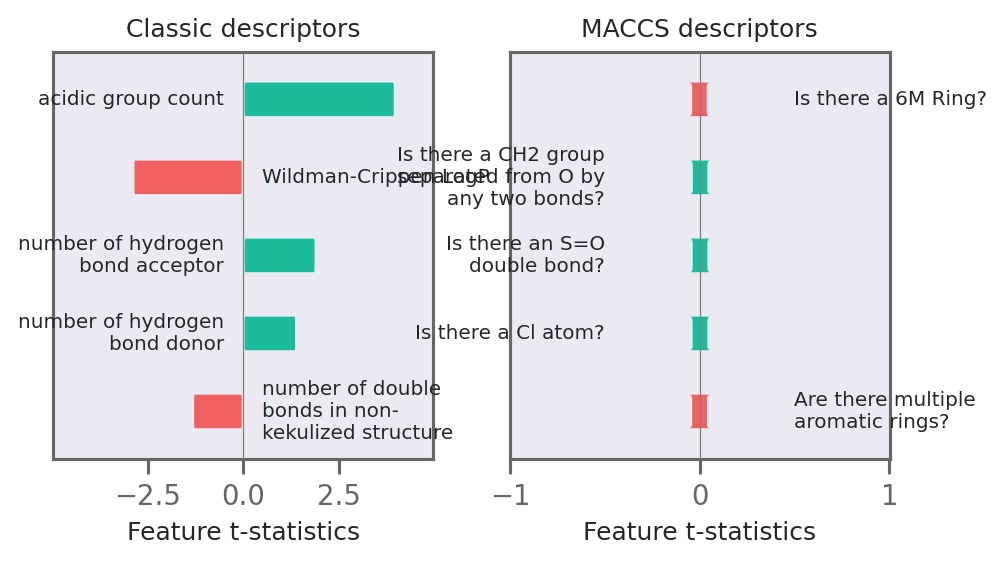

In [19]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator

desc_type = ['Classic', 'MACCS']
fig, ax = plt.subplots(nrows=1, ncols=len(desc_type), figsize=(6,3), dpi=180, squeeze=True)
i=0
for d in desc_type:
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    feature_importance = calc_ft_imp(space, space_tstats)
    if len(feature_importance.items())<5:
        feature_importance = {a: b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats)}# if abs(b) > 2.96}
        feature_importance = dict(sorted(feature_importance.items(),
                     key=lambda item: abs(item[1]),
                     reverse=True))
    if len(feature_importance.items()) > 5:
        feature_importance = {a:feature_importance[a] for a in list(feature_importance.keys())[:6]}
    plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'{d} descriptors')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
    i+=1
plt.savefig(f'desc.svg', dpi=180, bbox_inches='tight', transparent=False)
plt.show()

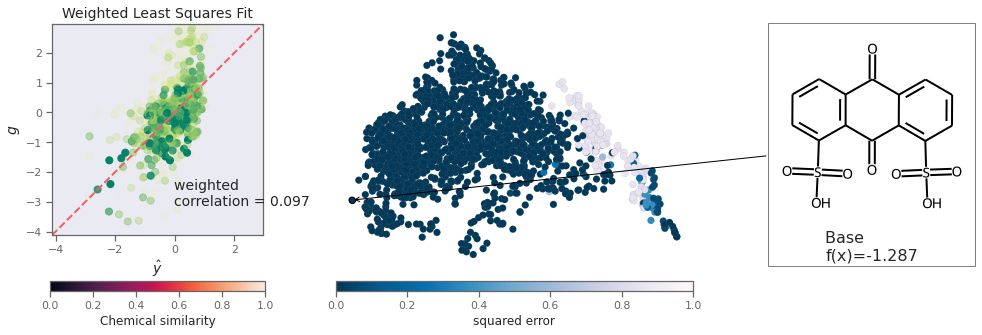

In [44]:
fkw = {'figsize': (6,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

fig = plt.figure(figsize=(10,5))
mpl.rc('axes', titlesize=12)
mpl.rc('font', size=16)
ax_dict = fig.subplot_mosaic('AABBB')

svg = plot_space_by_fit(space, [space[0]], figure_kwargs=fkw, 
                        mol_size=(200,200), offset=1, 
                        ax=ax_dict['B'], 
                        beta=beta)

ys = [e.yhat for e in space]
ys -= np.mean(ys)
x_mat = np.array([list(e.descriptors.descriptors)
                  for e in space]).reshape(len(space), -1)
y_wls = x_mat @ beta

lower = np.min(ys)
higher = np.max(ys)

w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space])

import matplotlib.colors as colors
normalizer = plt.Normalize(min(w), max(w))
cmap = plt.cm.summer_r(w)
cmap[:, -1] = w

def weighted_mean(x, w):
    return np.sum(x*w)/np.sum(w)
def weighted_cov(x, y, w):
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)
def weighted_correlation(x, y, w):
    return weighted_cov(x, y, w) / np.sqrt(weighted_cov(x, x, w) * weighted_cov(y, y, w))

corr = weighted_correlation(ys, y_wls, w)

ax_dict['A'].plot(np.linspace(lower, higher, 100), np.linspace(lower, higher, 100), '--', linewidth=2)
sc = ax_dict['A'].scatter(ys, y_wls, s=50, marker='o', c=cmap, cmap=plt.cm.summer_r(w)) # c=normalizer(w), cmap=cmap, lw=0.1, edgecolor='k')
# ax_dict['A'].text(max(ys) - 3, min(ys) + 1, f'correlation = {np.corrcoef(ys, y_wls)[0,1]:.3f}', fontsize=14)
ax_dict['A'].text(max(ys) - 3, min(ys) + 1, f'weighted \ncorrelation = {corr:.3f}', fontsize=14)
ax_dict['A'].set_xlabel(r'$\hat{y}$', fontsize=14)
ax_dict['A'].set_ylabel(r'$g$', fontsize=14)
ax_dict['A'].set_title('Weighted Least Squares Fit', fontsize=14)
ax_dict['A'].set_xlim(lower, higher)
ax_dict['A'].set_ylim(lower, higher)
ax_dict['A'].set_aspect(1.0/ax_dict['A'].get_data_ratio(), adjustable='box')
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.15, ax=ax_dict['A'])
cbar.set_label('Chemical similarity')
plt.tight_layout()
plt.savefig('Figure_1.png', dpi=300, bbox_inches="tight", transparent=False)

# Is the correlation low because we added noise to x?

array([[0.        , 0.5       , 0.4       , 1.        ],
       [1.        , 1.        , 0.4       , 1.        ],
       [0.94901961, 0.9745098 , 0.4       , 1.        ],
       ...,
       [0.96470588, 0.98235294, 0.4       , 1.        ],
       [0.99215686, 0.99607843, 0.4       , 1.        ],
       [0.97254902, 0.98627451, 0.4       , 1.        ]])

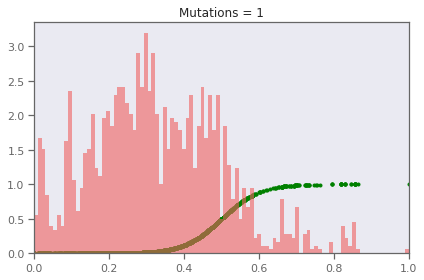

In [34]:
%matplotlib inline
plt.figure()
plt.hist([e.similarity for e in space], bins=99, edgecolor='none', label=d, alpha=0.6, density=True)
plt.scatter([e.similarity for e in space], w, marker='.', color='green', label='Sigmoid weights')
plt.title(f'Mutations = 1')
plt.xlim(0,1)
# plt.legend()
plt.tight_layout()
plt.show()

In [48]:
#Down sample to see all aliphatic compounds
chain_compounds = []
csmiles = []
for s in space:
    d = s.descriptors.descriptors
#     if or d[125]==1 or d[114]==1 or d[115]==1"
    if d[164]!=1  or d[162]!=1:
        chain_compounds.append(s)
        csmiles.append(s.smiles)
        
len(chain_compounds)

457

In [57]:
mols_10_atoms = []
for s in space:
    mol = MolFromSmiles(s.smiles)
    if len(mol.GetAtoms())<10:
        mols_10_atoms.append(s)
        
len(mols_10_atoms)

80

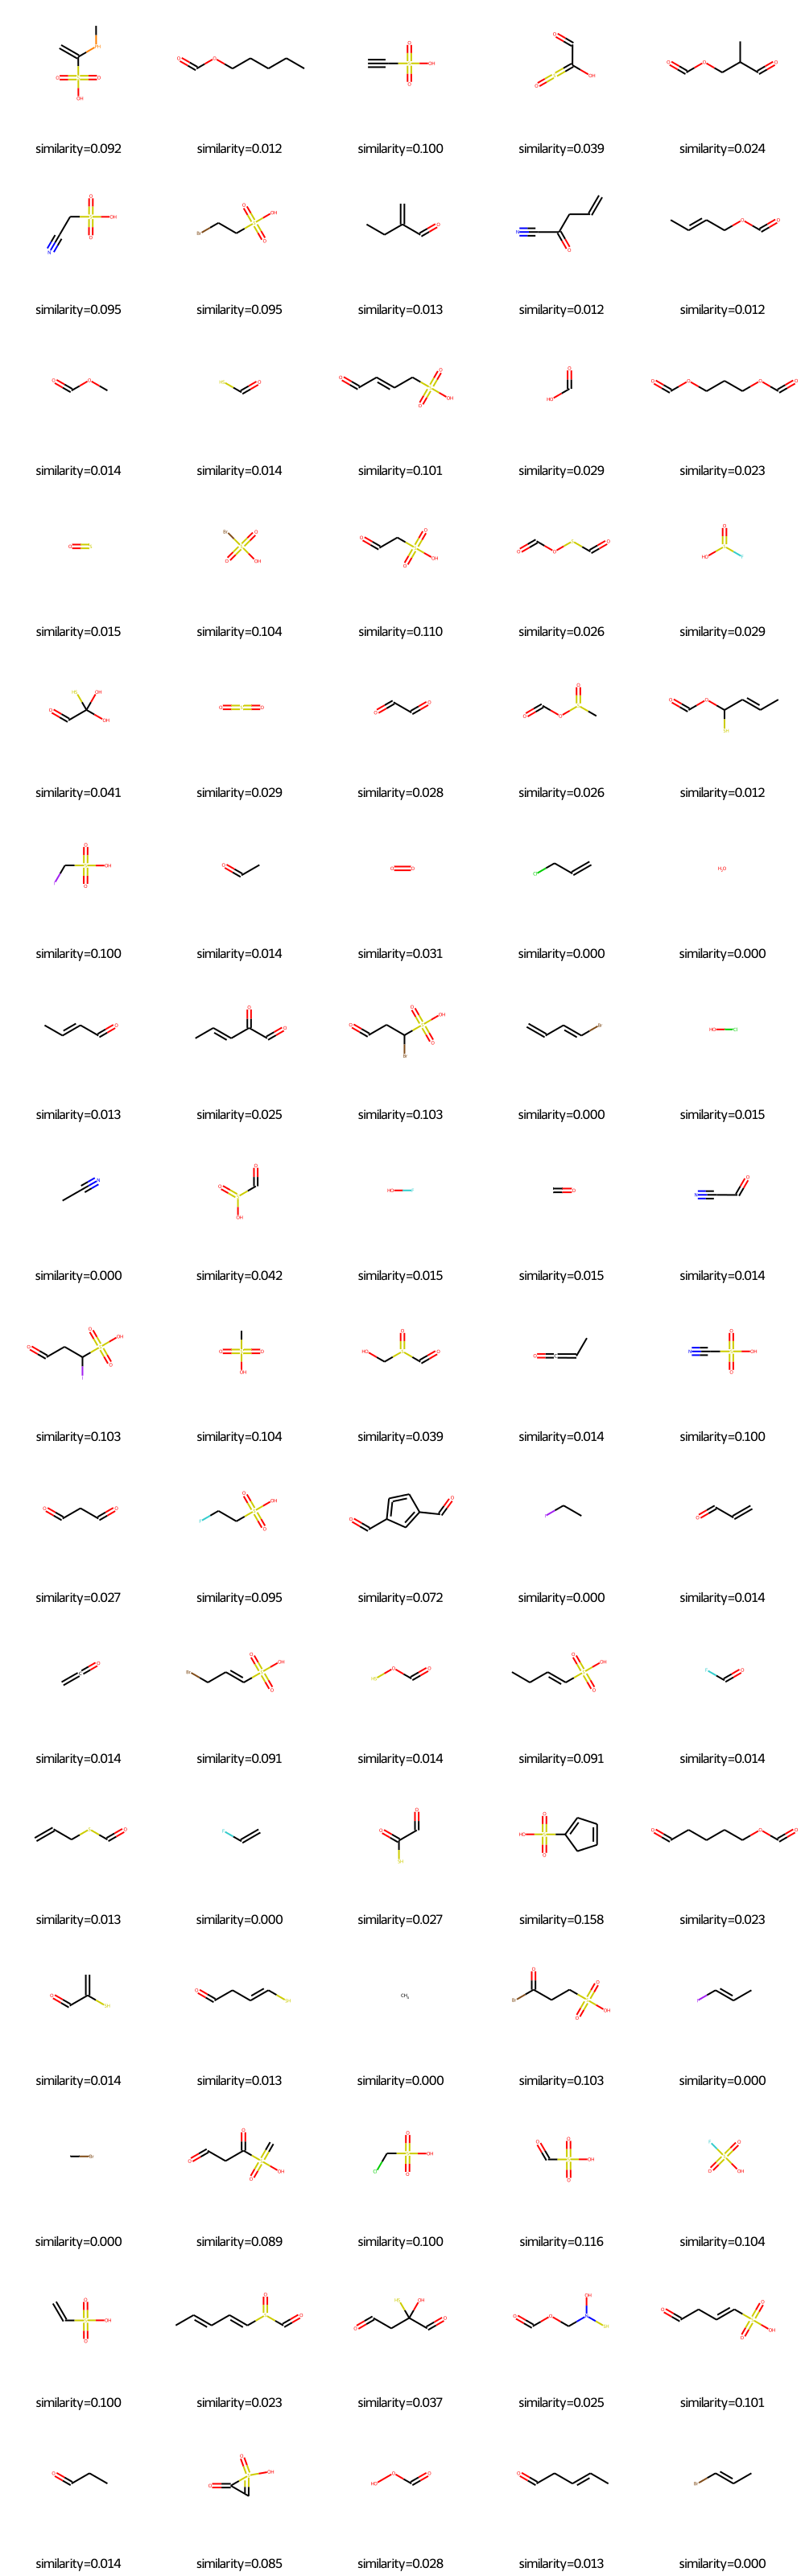

In [60]:
MolsToGridImage([MolFromSmiles(m.smiles) for m in mols_10_atoms], maxMols=500, 
                molsPerRow=5, 
                subImgSize=(200,200), 
                legends=[f'similarity={m.similarity:.3f}' for m in mols_10_atoms])

## Robustness to chemical space

In [31]:
# Get feature numbers
features = feature_dict(space)

In [32]:
# Above example is a baseline - 2500 mols with 3 mutations
baseline_set = [features[x] for x in feature_importance.keys()][:5]
if len(baseline_set) < 5:
    baseline_imp = {a: b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats)}
    baseline_imp = dict(sorted(baseline_imp.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
baseline_set = [features[x] for x in feature_importance.keys()][:5]
baseline_ohs = [0 if i not in baseline_set else 1 for i in range(len(features))]

In [33]:
baseline_set

[164, 131, 125, 88, 152]

In [29]:
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score, adjusted_rand_score

Baseline (full space): [164, 125, 131, 88, 99]
[ 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000]


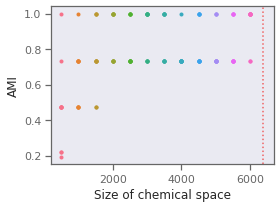

In [30]:
# Get subsets and calculate lime importances - bootstrap resampling
print('Baseline (full space):', baseline_set)
plt.figure(figsize=(4,3))
N = len(space)
size = np.arange(500,N,500)
print(size)
ami = {}
colors = sns.color_palette("husl", len(size))
for i, f in enumerate(size):
    # subsample space
    ami[f] = []
    for _ in range(10):
        idx = np.random.choice(np.arange(N), size=f, replace=True)
        subspace = [space[i] for i in idx]
        # get desc attributions
        ss_tstats, ss_beta = exmol.lime_explain(subspace, descriptor_type='MACCS')
        ss_imp = calc_ft_imp(subspace, ss_tstats)
        # ami needs sets of equal size, so 
        if len(ss_imp.items()) < 5:
            ss_imp = {a: b for a, b in zip(subspace[0].descriptors.descriptor_names, ss_tstats)}
            ss_imp = dict(sorted(ss_imp.items(),
                         key=lambda item: abs(item[1]),
                         reverse=True))
        if len(ss_imp.items()) > 5:
            ss_imp = {a:ss_imp[a] for a in list(ss_imp.keys())[:6]}
        ss_set = [features[x] for x in ss_imp.keys()][:5]
        ss_ohs = [0 if i not in ss_set else 1 for i in range(len(features))]
        a = adjusted_rand_score(baseline_ohs, ss_ohs)
        ami[f].append(a)
        plt.scatter(f, a, color=colors[i], marker='.')

plt.axvline(x=N, linestyle=':')
plt.xlabel('Size of chemical space')
plt.ylabel('AMI')
plt.tight_layout()
plt.savefig('ami.png', dpi=300, bbox_inches='tight')

In [31]:
df = pd.DataFrame.from_dict(ami, orient='index')
df.index.rename('Size of Chemical Space', inplace=True)
stacked = df.stack().reset_index()
stacked.rename(columns={'level_1': 'Lable', 0: 'AMI'}, inplace=True)

<IPython.core.display.Javascript object>


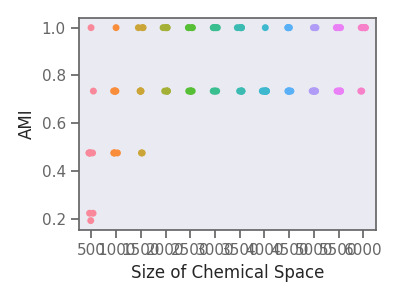

In [88]:
%matplotlib notebook

plt.figure(figsize=(4,3))
ax = sns.stripplot(data=stacked, x='Size of Chemical Space', y='AMI', jitter=0.1)
plt.tight_layout()
plt.savefig('ami.svg', dpi=300, bbox_inches='tight')

## Figure showing effect of mutation number, alphabet and size of chemical space


In [42]:
# Mutation

smi = soldata.SMILES[3826]
tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic':[], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
muts = [1,3,5]
for i in muts:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        spaces[d].append(space)    
        tstats[d].append(t)
#         print(tstats)
        beta[d].append(b)
#         print(beta)

🤘Done🤘: 100%|██████████| 1460.0/1460 [00:03<00:00, 377.83it/s]                      
🤘Done🤘: 100%|██████████| 1513.0/1513 [00:04<00:00, 315.86it/s]                      
🤘Done🤘: 100%|██████████| 1741.0/1741 [00:05<00:00, 318.60it/s]                     
🤘Done🤘: 100%|██████████| 1740.0/1740 [00:05<00:00, 296.05it/s]                     
🤘Done🤘: 100%|██████████| 1608.0/1608 [00:04<00:00, 365.03it/s]                     
🤘Done🤘: 100%|██████████| 1592.0/1592 [00:04<00:00, 324.32it/s]                     


<IPython.core.display.Javascript object>


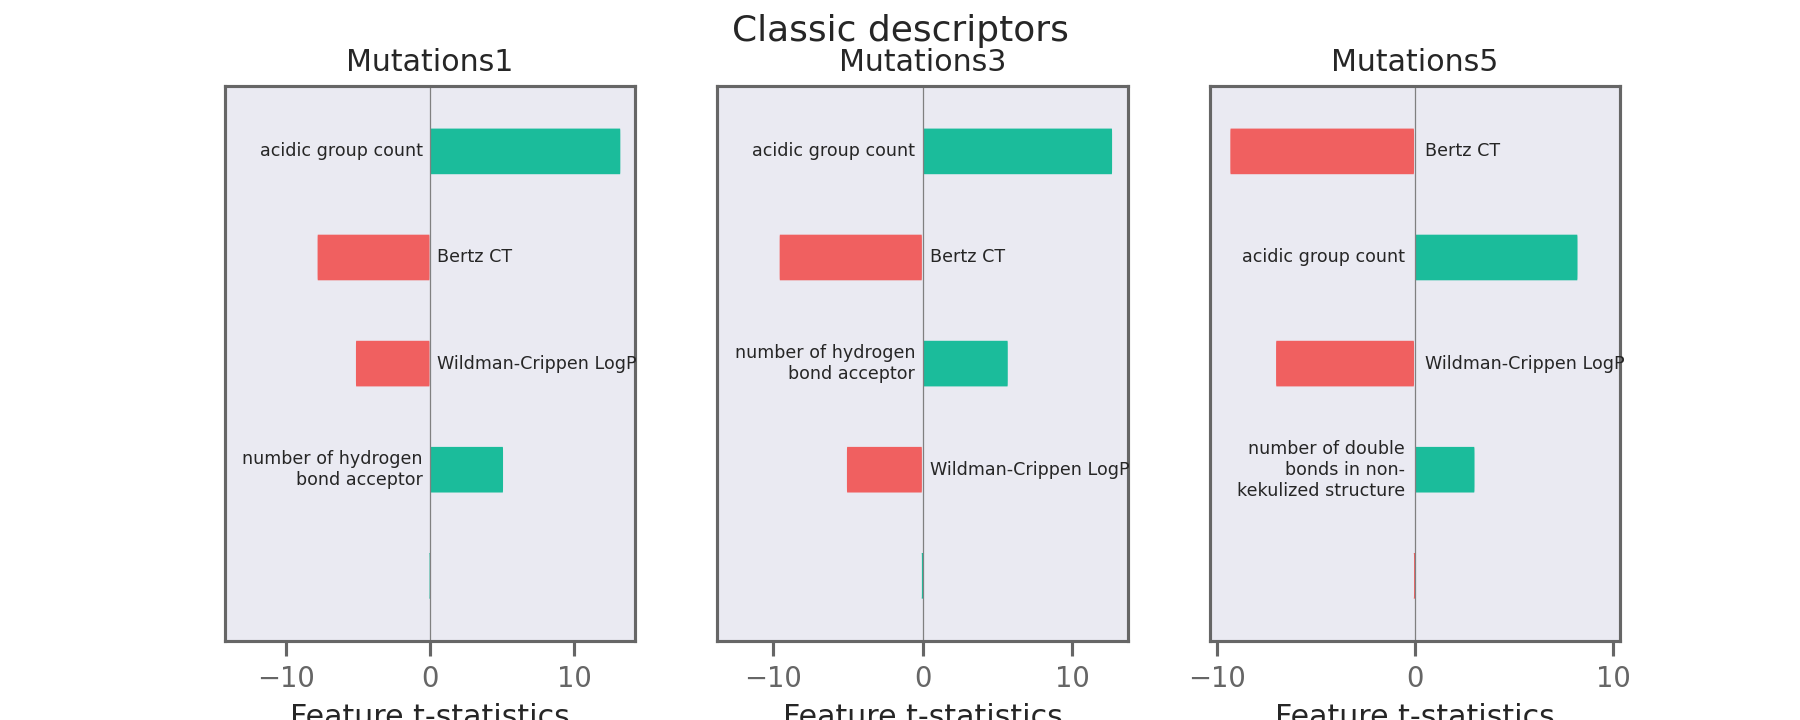

<IPython.core.display.Javascript object>


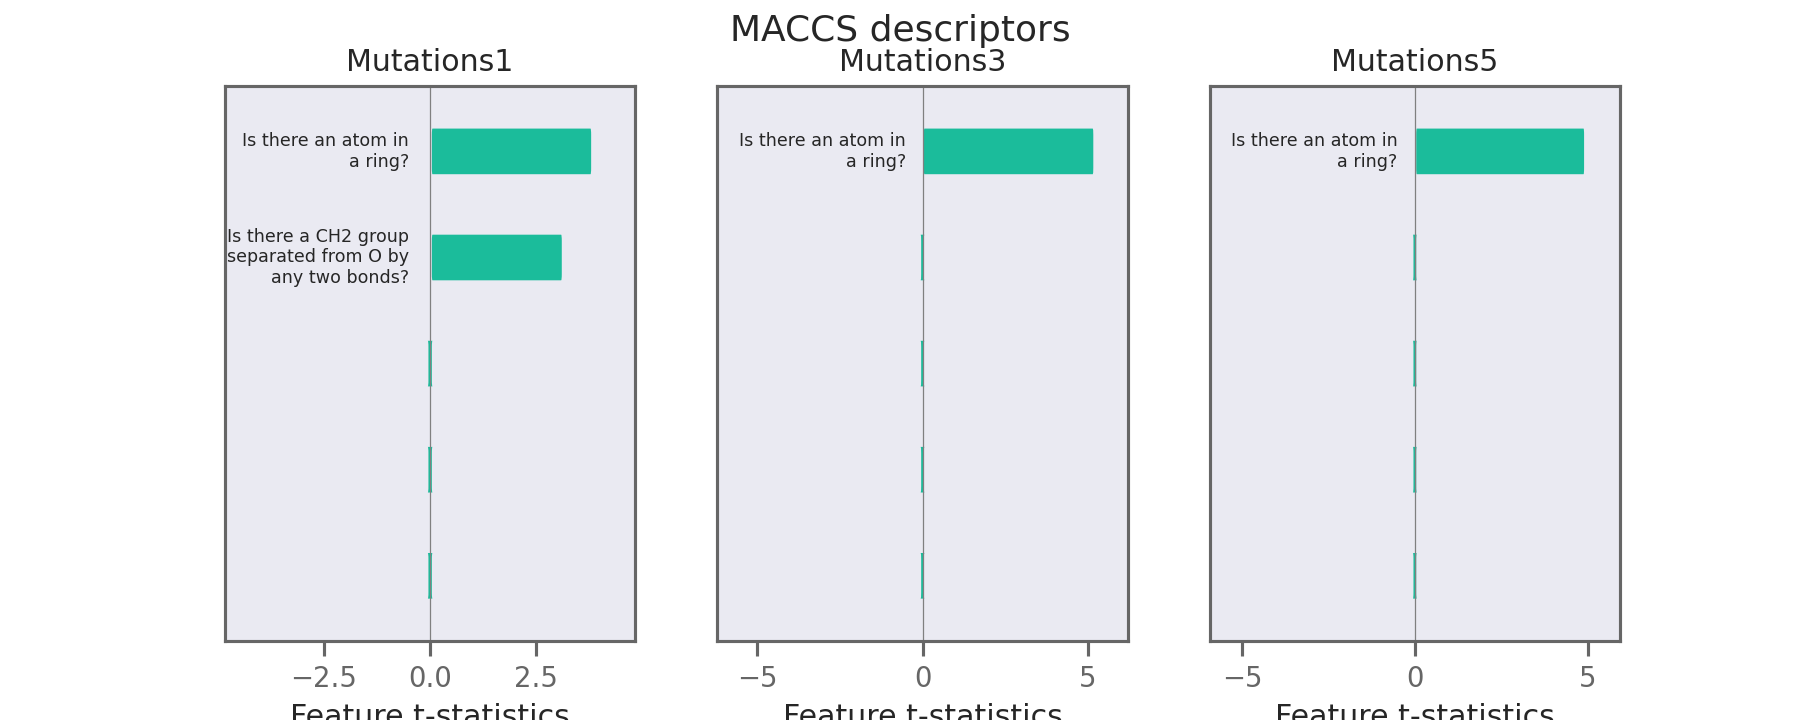

In [43]:

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Mutations{muts[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_mutations.png', dpi=180, bbox_inches='tight')


<IPython.core.display.Javascript object>


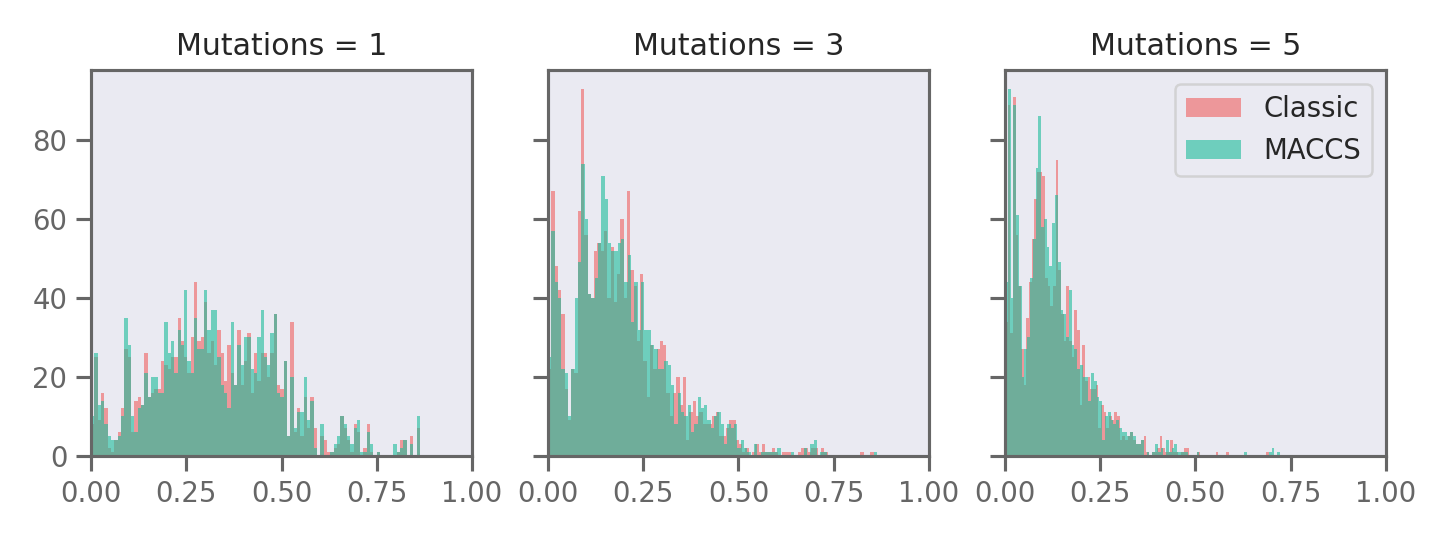

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    for d in desc_type:
        axs[i].hist([e.similarity for e in spaces[d][i][1:]], bins=99, edgecolor='none', label=d, alpha=0.6)
        axs[i].set_title(f'Mutations = {n}')
        axs[i].set_xlim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [45]:
# Alphabet

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ['Classic', 'MACCS']
alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

for a in alphs:
    for d in desc_type:
        stoned_kwargs={'num_samples': 2500, 'alphabet':alphs[a],'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)

🤘Done🤘: 100%|██████████| 1675.0/1675 [00:04<00:00, 336.57it/s]                     
🤘Done🤘: 100%|██████████| 1704.0/1704 [00:05<00:00, 302.31it/s]                      
🤘Done🤘: 100%|██████████| 1727.0/1727 [00:05<00:00, 311.78it/s]                     
🤘Done🤘: 100%|██████████| 1626.0/1626 [00:05<00:00, 292.88it/s]                     
🤘Done🤘: 100%|██████████| 1694.0/1694 [00:05<00:00, 324.69it/s]                      
🤘Done🤘: 100%|██████████| 1618.0/1618 [00:05<00:00, 304.69it/s]                      


<IPython.core.display.Javascript object>


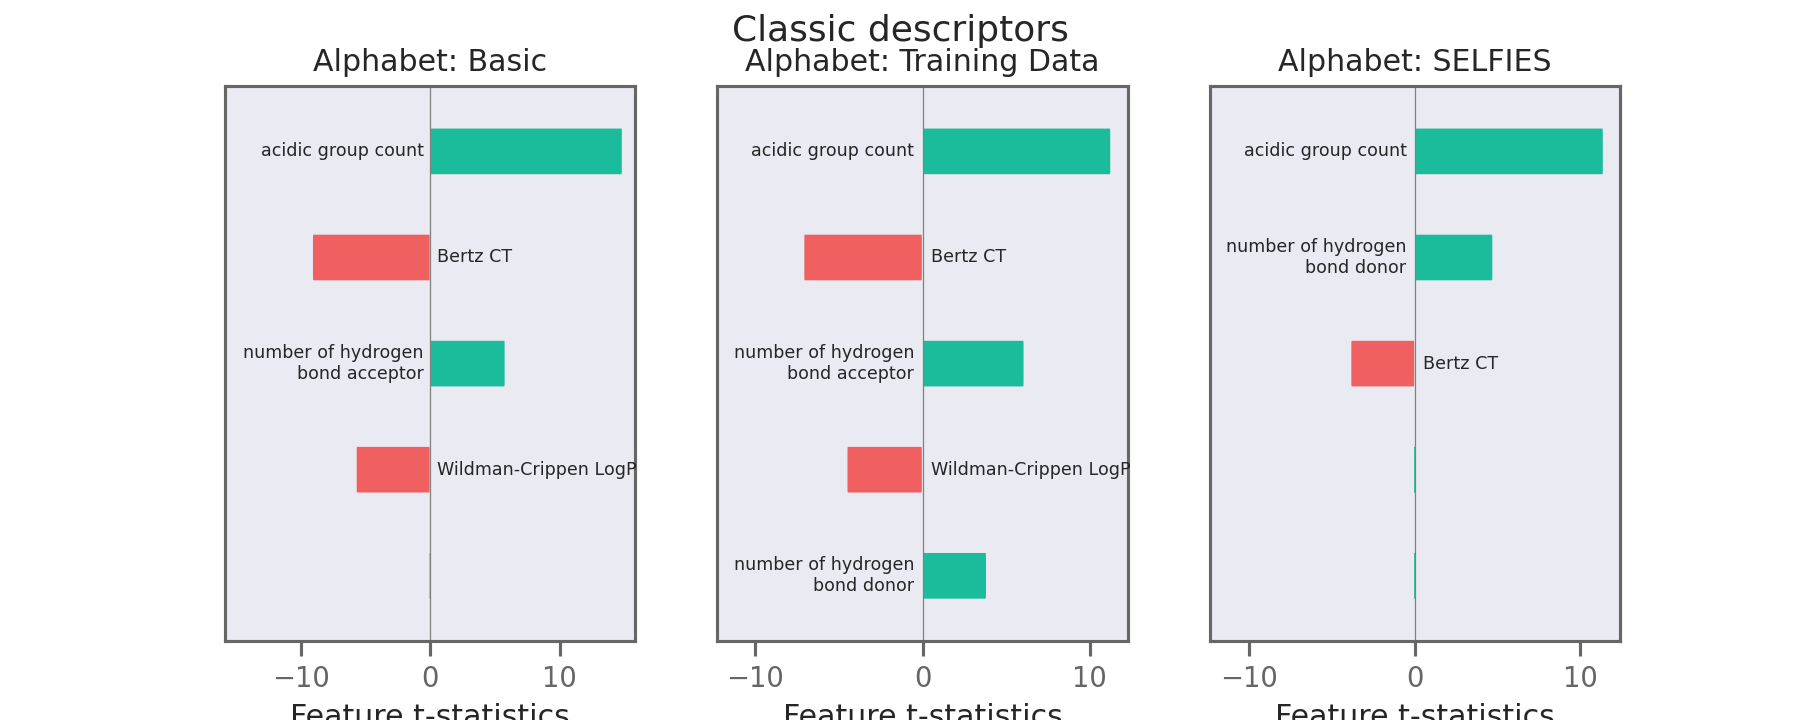

<IPython.core.display.Javascript object>


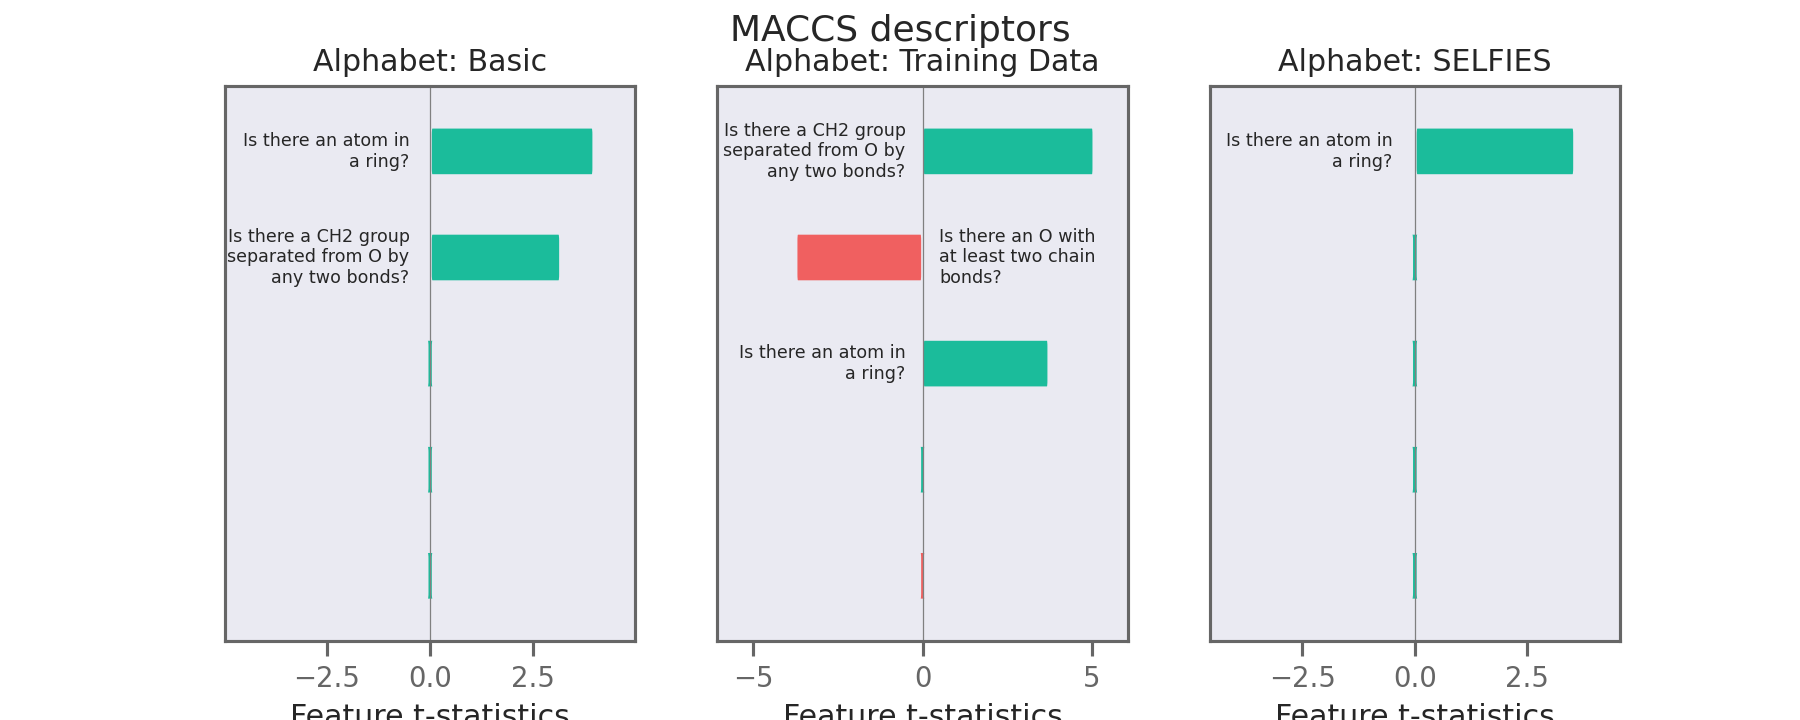

In [46]:
akeys = list(alphs.keys())

for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Alphabet: {akeys[i]}')
    # plot_with_desc(feature_importance, s, desc_type='classic', output_file=f'mutation_classic_{i}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_alphabet.png', dpi=180, bbox_inches='tight')


In [47]:
# Size of space

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
space_size = [1500, 2000, 2500]

for a in space_size:
    for d in desc_type:
        stoned_kwargs={'num_samples': a, 'alphabet': exmol.get_basic_alphabet(),'max_mutations':2}
        space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
        spaces[d].append(space)
        t, b = exmol.lime_explain(space, descriptor_type=d)
        tstats[d].append(t)
        beta[d].append(b)

🤘Done🤘: 100%|██████████| 1068.0/1068 [00:02<00:00, 502.45it/s]                      
🤘Done🤘: 100%|██████████| 1030.0/1030 [00:02<00:00, 435.58it/s]                      
🤘Done🤘: 100%|██████████| 1351.0/1351 [00:03<00:00, 369.63it/s]                     
🤘Done🤘: 100%|██████████| 1362.0/1362 [00:03<00:00, 347.11it/s]                      
🤘Done🤘: 100%|██████████| 1684.0/1684 [00:05<00:00, 326.31it/s]                     
🤘Done🤘: 100%|██████████| 1673.0/1673 [00:05<00:00, 295.10it/s]                      


<IPython.core.display.Javascript object>


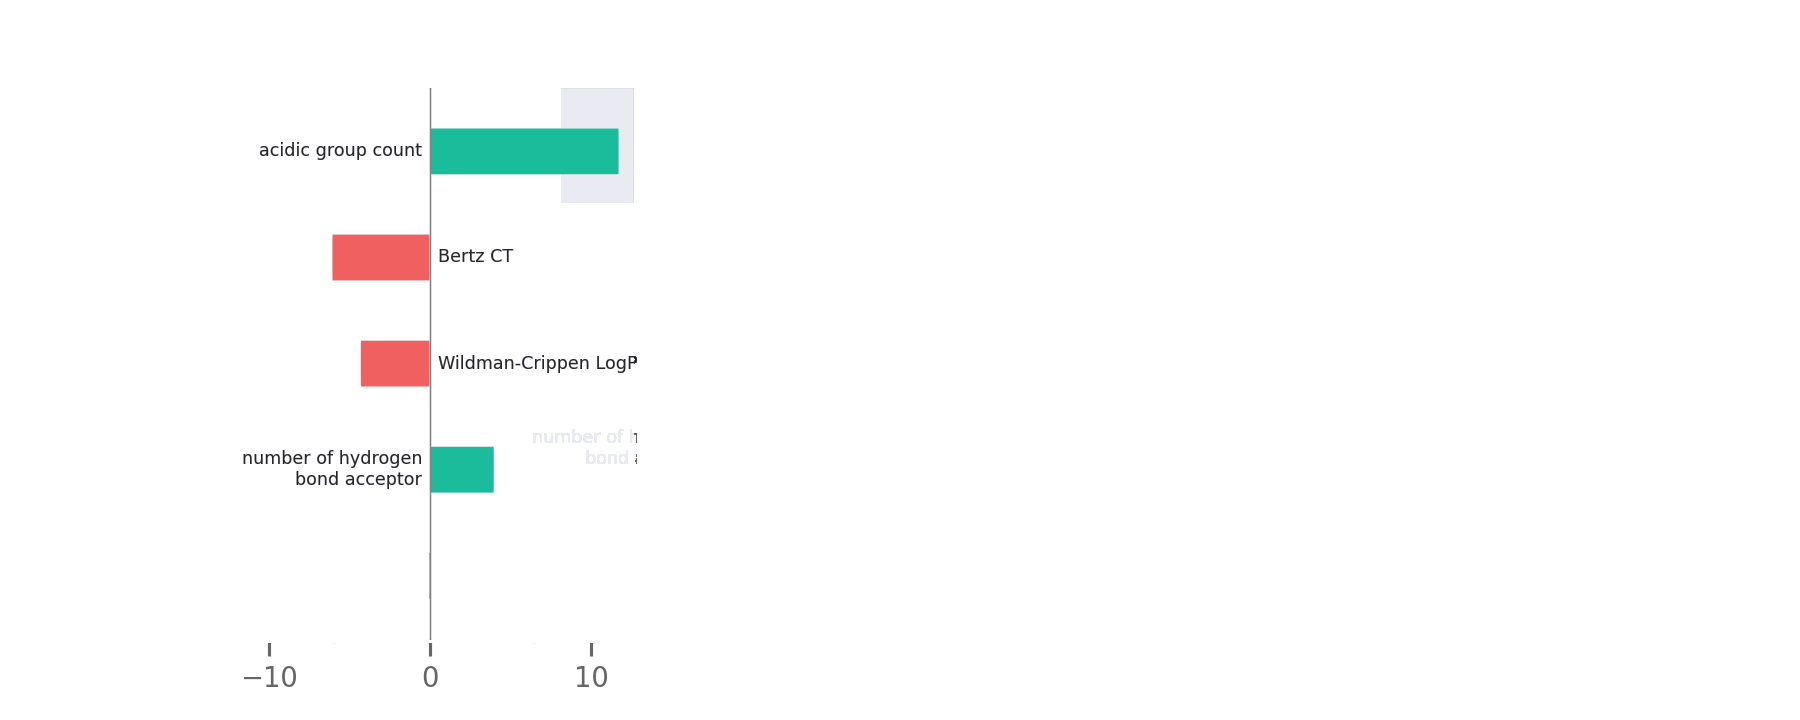

<IPython.core.display.Javascript object>


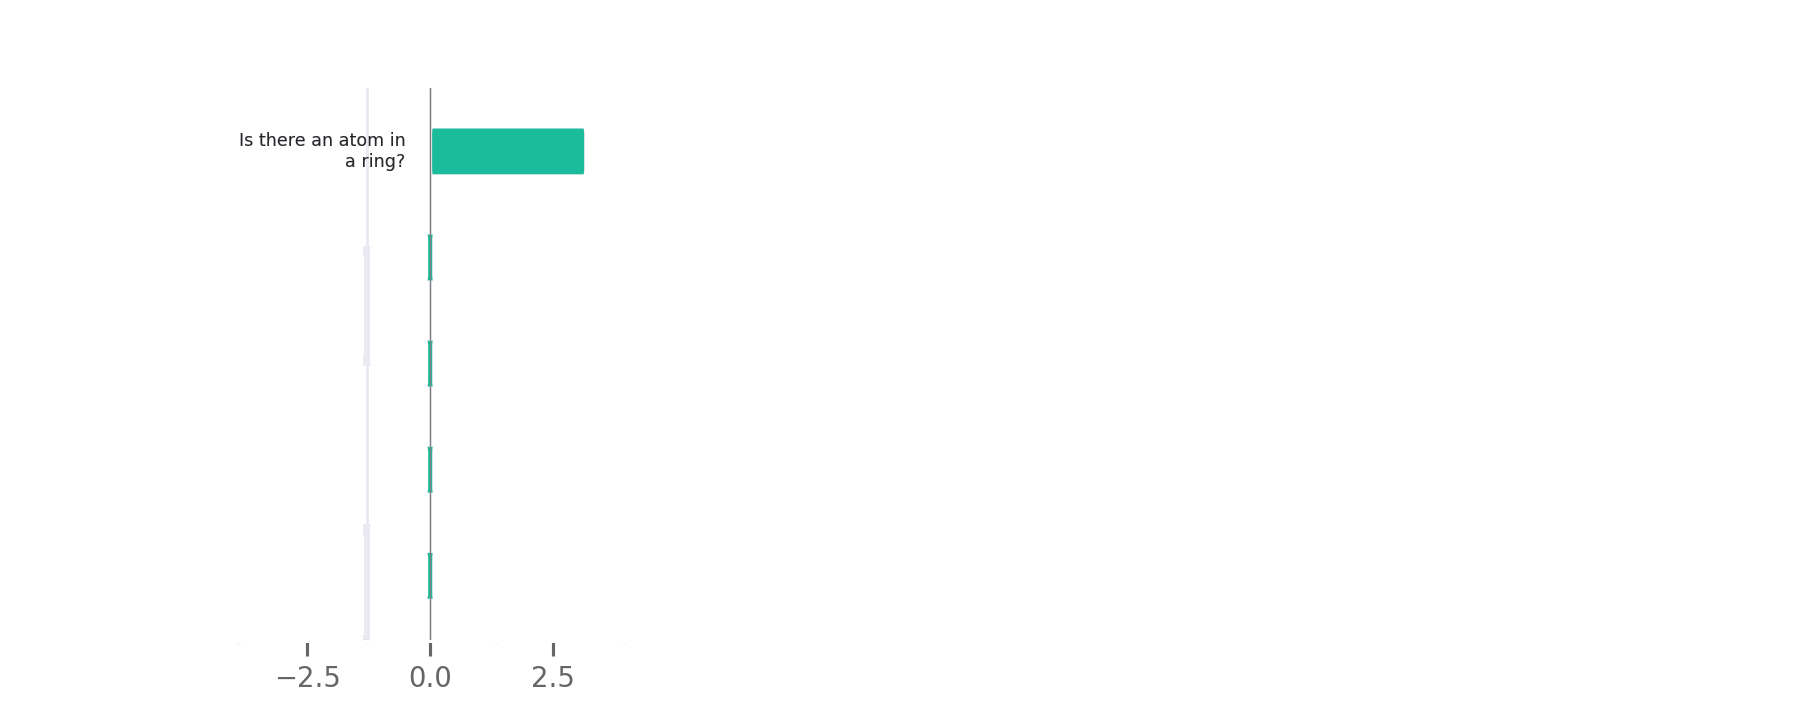

In [48]:
for d in desc_type:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=len(tstats[d]), figsize=(10,4), dpi=180, squeeze=True)
    for s, t, b in zip(spaces[d], tstats[d], beta[d]):
        feature_importance = calc_ft_imp(s, t)
        plot_desc(feature_importance, d, output_file=None, 
                  ax=ax[i], title=f'Size: {space_size[i]}')
        i += 1
    fig.suptitle(f'{d} descriptors')
    plt.savefig(f'{d}_size.png', dpi=180, bbox_inches='tight')

## Miscellaneous cells

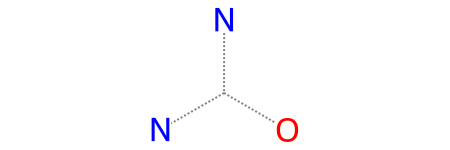

In [49]:
from rdkit.Chem import MolFromSmarts
mol = MolFromSmarts('[#7]~[#6](~[#8])~[#7]')
mol

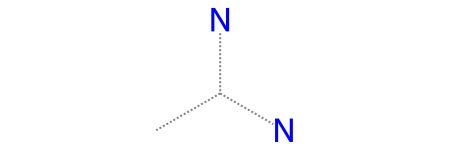

In [50]:
MolFromSmarts('[#7]~[#6](~[#6])~[#7]')

In [81]:
from rdkit.Chem.Draw import MolToFile 
MolToFile(mol, 'n_3.svg')

In [28]:
## Functions to highlight molecules by significant smarts

from IPython.display import SVG
from rdkit.Chem import MolFromSmarts, Mol
from rdkit.Chem.Draw import rdDepictor, MolDrawOptions, rdMolDraw2D, MolToImage as mol2img
from collections import defaultdict
from matplotlib import colors, cm

def get_significant_SMARTS(example, tstats):
    descriptors = list(example.descriptors.descriptors)
    descriptor_names = list(example.descriptors.descriptor_names)
    maccs_smarts = pd.read_csv('../exmol/MACCSkeys.txt', sep='\t')
#     descriptor_smarts = {a:b for a,b in zip(descriptor_names, maccs_smarts['SMARTS'])}
    desc_list = []
    for t, d, s in zip(tstats, descriptor_names, maccs_smarts['SMARTS']):
        if t > 2.96:
            desc_list.append([s, float(t)])
    return desc_list

def get_highlight_lists(smi, descriptor_list):
    print(smi)
    aidx, bidx = [], []
    arads = {}
    highlight_atoms = defaultdict(list)
    highlight_bonds = defaultdict(list)
    count = 0
    mol = MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)
    for t in descriptor_list:
        print(t[0])
        patt = MolFromSmarts(t[0])
        rdDepictor.Compute2DCoords(patt)

        que_mc = Mol(mol.ToBinary())  # make a copy of the Mol object
        matching = que_mc.GetSubstructMatches(patt)
        matching = [a for b in matching for a in b]
        aidx.append(matching)

        for a in matching:
            highlight_atoms[a].append(cmap(normalizer(t[1])))
            arads[a] = 0.2
        if len(matching) > 1:
            count += 1
        if count > 5:
            break
    return aidx, highlight_atoms, arads
    
def draw_with_highlights(smi, highlight_atoms, arads, name='test.svg'):
    d = rdMolDraw2D.MolDraw2DSVG(1000, 300)
    dos = MolDrawOptions()
    dos.useBWAtomPalette()
    dos.minFontSize = 10
    dos.atomHighlightsAreCircles = False
    dos.fillHighlights=True
    d.SetDrawOptions(dos)
    d.DrawMoleculeWithHighlights(MolFromSmiles(smi), '', dict(highlight_atoms), {}, arads, {})
    d.FinishDrawing()

    img = d.GetDrawingText()
    with open(name, 'w+') as f:
        f.write(img)
    
    return d

space_tstats, beta = exmol.lime_explain(space, descriptor_type='MACCS')
cfs = exmol.rcf_explain(space, nmols=5)

normalizer = colors.Normalize(min(space_tstats), max(space_tstats))
cmap = cm.seismic
imgs = []
for i, m in enumerate(cfs):
    tstats = list(m.descriptors.descriptors) * beta
    descriptor_list = get_significant_SMARTS(m, tstats)
    descriptor_list.sort(key=lambda x: x[1], reverse=True)
    aidx, highlight_atoms, arads = get_highlight_lists(m.smiles, descriptor_list)
    imgs.append(draw_with_highlights(m.smiles, highlight_atoms, arads, name=f'm{i}.svg'))

O=C1c2cccc(S(=O)(=O)O)c2C(=O)c2c1cccc2S(=O)(=O)O
[#16]-[#8]
[R]
Cl
O=C1c2c(cccc2S(=O)(=O)O)-c2cccc(S(=O)(=O)O)c21
[#16]-[#8]
[R]
Cl
NS(=O)(=O)c1cccc2c1C(=O)c1c(cccc1S(=O)(=O)O)C2=O
[#16]-[#8]
[R]
Cl
O=C1C=C2C(=O)c3cccc(S(=O)(=O)O)c3C(O)(O)C2OC1
[#16]-[#8]
[R]
Cl
O=C1C=C2C=CCC(S(=O)(=O)O)=C2C(=O)CC(S(=O)(=O)O)=CCC1
[#16]-[#8]
[R]
Cl


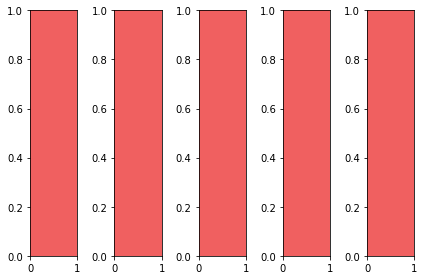

In [119]:
import skunk

fig, axs = plt.subplots(ncols=len(imgs))

# important line where we set ID
for i, im in enumerate(imgs):
    skunk.connect(axs[i], f'sk{i}')
    # Overwrite using file path to my svg
    # Can also use a string that contains the SVG 
    svg = skunk.insert(
        {
            f'sk{i}': f'm{i}.svg'
        })
plt.tight_layout()
skunk.display(svg)

# write to file
with open('replaced.png', 'w') as f:
    f.write(svg)
# or in jupyter notebook


In [106]:
from rdkit.Chem import MolFromSmarts
smi = soldata.SMILES[100]
mol = MolFromSmiles(smi)
rdDepictor.Compute2DCoords(mol)

rdDepictor.Compute2DCoords(patt)

que_mc = Chem.Mol(mol.ToBinary())  # make a copy of the Mol object
matching = que_mc.GetSubstructMatch(patt)
que_mc

# matching = mol.GetSubstructMatch(patt)

NameError: name 'patt' is not defined

In [62]:
from rdkit.Chem.Draw import MolDrawOptions
from IPython.display import SVG

aidx, bidx = exmol.moldiff(mol, patt)

d = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(1000, 300)
dos = MolDrawOptions()
dos.useBWAtomPalette()
dos.minFontSize = 10
d.SetDrawOptions(dos)
d.DrawMolecule(mol, highlightAtoms=aidx,
               highlightBonds=bidx)
#                highlightAtomColors='cyan',
#                highlightBondColors='cyan')
d.FinishDrawing()
SVG(d.GetDrawingText())

img = d.GetDrawingText()
with open('test.svg', 'w+') as f:
    f.write(img)

NameError: name 'patt' is not defined

In [164]:
cfs = exmol.rcf_explain(space, nmols=4)

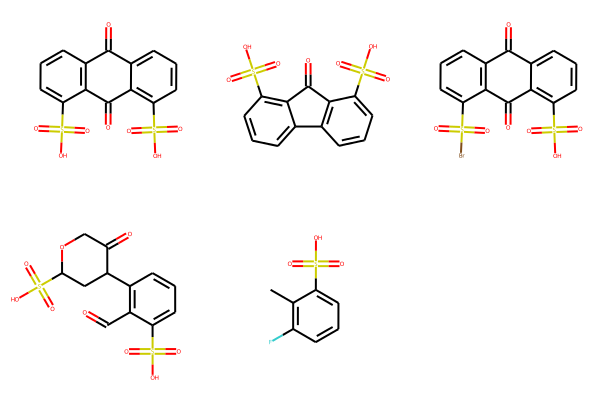

In [174]:
mols = [MolFromSmiles(m.smiles) for m in cfs]
MolsToGridImage(mols)

In [48]:
mpl.__version__

'3.4.2'